# Boston Airbnb data understanding and price prediction. ####

## Business Understanding

We would like to answer various questions using the given Boston Airbnb data:

1. How are the prices affected by time?

2. How are the listings distributed? Are there many shared rooms?

3. The factors that influence the price of a property on Airbnb in Boston and how they relate.

4. ML model to predict the price given this dataset

----

## Data Understanding - Access

The dataset contains 3 files:

1. listings.csv: contains information about the listings and their location, as well as host information and guest fees, among other things.

2. calendar.csv: contains dates of availability and price

3. reviews.csv: review data for the listings. (will not be used in the analysis)

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split #split
from sklearn import metrics
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Gather the data
df_listings = pd.read_csv("Boston_listings.csv")
print("Columns of the table are", df_listings.columns)
print("Shape of the data is", df_listings.shape )

Columns of the table are Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommoda

In [3]:
# Find number of listings and number of hosts
listings_numbers = len(df_listings['id'].unique())
hosts_numbers = len(df_listings['host_id'].unique())  
print("We have {} total numbers of listings and they are provided by {} hosts".format(listings_numbers, hosts_numbers))

# Find percentages of missing values in columns that has NANs
percent_missing = df_listings.isnull().sum() * 100 / len(df_listings)
columns_with_nan = percent_missing[percent_missing > 0]
columns_with_nan

We have 3585 total numbers of listings and they are provided by 2181 hosts


summary                           3.988842
space                            29.483961
neighborhood_overview            39.470014
notes                            55.090656
transit                          35.983264
access                           41.534170
interaction                      43.347280
house_rules                      33.249651
thumbnail_url                    16.708508
medium_url                       16.708508
xl_picture_url                   16.708508
host_location                     0.306834
host_about                       36.513250
host_response_time               13.138075
host_response_rate               13.138075
host_acceptance_rate             13.138075
host_neighbourhood                9.456067
neighbourhood                    15.146444
neighbourhood_group_cleansed    100.000000
city                              0.055788
zipcode                           1.059972
market                            0.390516
property_type                     0.083682
bathrooms  

In [4]:
#Read Calendar data
df_calendar = pd.read_csv("Boston_calendar.csv")
print("Shape of the calendar dataset is ", df_calendar.shape)
print("Min date is {} and max date is {}". format(df_calendar['date'].min(), df_calendar['date'].max()))
print("columns of the calendar table are", df_calendar.columns)

Shape of the calendar dataset is  (1308890, 4)
Min date is 2016-09-06 and max date is 2017-09-05
columns of the calendar table are Index(['listing_id', 'date', 'available', 'price'], dtype='object')


#### Observations
 1. Listings and Calendars tables have common column which can be used in merging. 
 2. Same host can do several listing.
 3. Dataset contains information for 1 year from September 2016 till September 2017.
 4. There are several columns that has 100% missing values which most probably will be dropped entirley.
 

----

## Data Preparation

1. Merge Listings and Calendars tables using listing_id.
2. Drop columns and add modes and means for several data columns.

In [5]:
#Merge the two tables on the Listing_id
df_listings = df_listings.rename(index=str, columns={"id": "listing_id"})
df_merged = pd.merge(df_calendar, df_listings, on = 'listing_id')
df_merged.columns

Index(['listing_id', 'date', 'available', 'price_x', 'listing_url',
       'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description',
       'experiences_offered', 'neighborhood_overview', 'notes', 'transit',
       'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url',
       'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_ty

In [6]:
# Function to set indicators for get extra fee 
def get_extra_people_fee(row):
    ''' Return 1 if there is fee for extra people '''
    if row['extra_people'] == '$0.00':
        return 0.0
    else:
        return 1.0

    
#Get month and year from date.
def get_month_from_date(row):
    return int(row['date'].split('-')[1])

def get_year_from_date(row):
    return int(row['date'].split('-')[0])


# Function that takes the merged dataFrame and clean its cols from missing data.
def prepare_data(df):
        
    '''
    Input:
    df: Merged DataFrame
    
    Output:
    
    DataFrame that has:
    1- Columns dropped.
    2- New year and month columns.
    3- New price column without $ sign (Float).
    4- Modes added in bedrooms, beds and bathrooms columns.
    5- 0 and 1 as an indication for wether if there is fee for extra people in the property.
    6- Fill in some cols with mean value.
    '''

    # Drop columns that are not necessary for the analysis.
    columns_to_drop = ['available', 'host_id','host_location','host_acceptance_rate','host_neighbourhood',
                   'host_total_listings_count', 'weekly_price', 'monthly_price',
                   'security_deposit', 'cleaning_fee', 'calendar_updated',
                   'listing_url','last_scraped' ,'scrape_id', 'name', 'summary', 'space', 'description',
                   'experiences_offered', 'street', 'neighbourhood',
                   'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
                   'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                   'city', 'state', 'market', 'smart_location', 'country_code', 'country',
                   'is_location_exact', 'square_feet', 'has_availability', 'availability_30',
                   'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped',
                  'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'price_y',
                  'reviews_per_month', 'amenities', 'neighbourhood_group_cleansed',
                   'host_since', 'host_response_rate', 'host_verifications', 'zipcode', 'house_rules', 'interaction', 'access']

    df = df.drop(columns = columns_to_drop)
    
    # Split Year and Month
    df['month'] = df.apply(lambda row: get_month_from_date(row),axis=1)
    df['year'] = df.apply(lambda row: get_year_from_date(row),axis=1)
    df = df.drop(columns = ['date'])
    
    #remove rows where price_x == nan
    df = df.dropna(subset=['price_x'])

    #convert price to float (Remove $ sign) and drop the price_x column
    df['price'] = df['price_x'].astype(str)
    df['price'] = df['price'].str.replace("[$, ]", "").astype("float")
    df = df.drop(columns = ['price_x'])

    # Add modes for the missing values below
    df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])
    df['beds'] = df['beds'].fillna(df['beds'].mode()[0])
    df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
    
    df['extra_people_fee'] = df.apply(lambda row: get_extra_people_fee(row), axis=1)
    df = df.drop(columns=['extra_people'])
        
    #fill missing values for review scores columns
    review_scores_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                         'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                        'review_scores_value']
    
    for column in review_scores_columns:
        df[column].fillna(df[column].mean(), inplace = True)
    
    return df     


In [7]:
# Clean the data using the function
df = prepare_data(df_merged)

----

## Data Understanding - Analysis

After cleaning the data we can now do some analysis to explore more features.

In [8]:
#find minimum, maximum and average price for listing
min_price = df['price'].min()
max_price = df['price'].max()
mean_price = df['price'].mean()

print('Minimum price per listing is {}'.format(min_price))
print('Maximum price per listing is {}'.format(max_price))
print('Average price per listing is {}'.format(mean_price))

Minimum price per listing is 11.0
Maximum price per listing is 7163.0
Average price per listing is 198.43890942511862


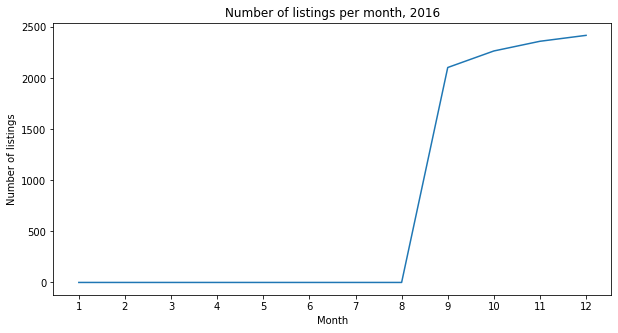

In [9]:
#find number of total number of listings for each month in 2016
number_of_listings_by_month = pd.Series([12])
for i in range(1, 13):
    number_of_listings_by_month[i] = len(df[(df['month'] == i) & (df['year'] == 2016)]['listing_id'].unique())
    
number_of_listings_by_month = number_of_listings_by_month.drop(0)

#plot
plt.figure(figsize=(10,5))
plt.plot(number_of_listings_by_month)
plt.xticks(np.arange(1, 13, step=1))
plt.ylabel('Number of listings')
plt.xlabel('Month')
plt.title('Number of listings per month, 2016')
plt.savefig('number of available listings.png')
plt.show()

From the figure above, we can see in 2016 it seems that the number of available listings are higher during Christmas season.

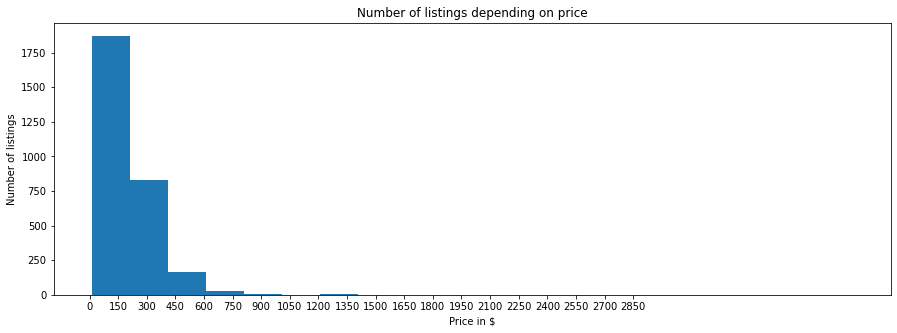

In [10]:
#get the average price for each listing
mean_price_for_listing = df.groupby('listing_id').mean()['price']

#plot
plt.figure(figsize=(15,5))
plt.hist(mean_price_for_listing, bins=20)
plt.xticks(np.arange(0, 3000, step=150))
plt.ylabel('Number of listings')
plt.xlabel('Price in $')
plt.title('Number of listings depending on price')

# Save the fig.
plt.savefig('Price distrubution.png')
# Plot the fig.
plt.show()

From the Figure above, it seems that the highest distribution in the price is approximately between 50 and 200 USD

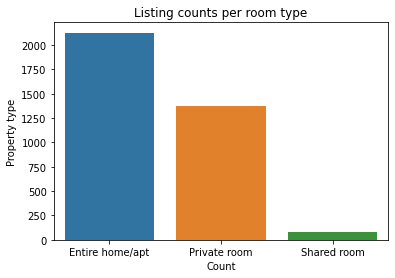

In [11]:
#Visualise the listings per room type
fig = sns.countplot(x="room_type", data=df_listings)

#Plot and save
plt.xlabel("Count")
plt.ylabel("Property type")
plt.title("Listing counts per room type") 
plt.savefig('Listing counts per room type.png')
plt.show(fig)

Entire home and apartments has the highest number of listings, on the other hand the shared room comes at the last place.

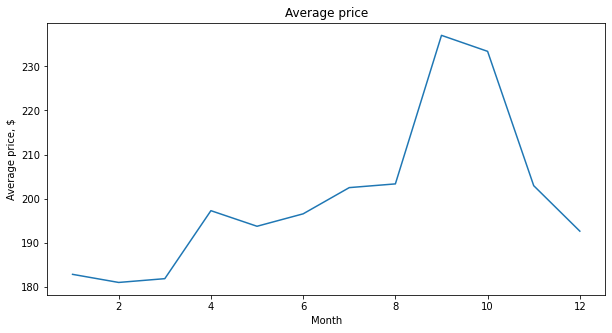

In [12]:
#find average price by month
average_price_by_month = df.groupby(['month'])['price'].mean()

#plot
plt.figure(figsize=(10,5))
plt.plot(average_price_by_month)
plt.ylabel('Average price, $')
plt.xlabel('Month')
plt.title('Average price')

plt.savefig('Average price for month')

plt.show()

From the figure above we can conlude that the average price in Boston is highest by the end of August and September till it starts to low down again from October till December. There is not enough data to better confirm but it looks like the listing price drops between November and February and starts raising up again in March.

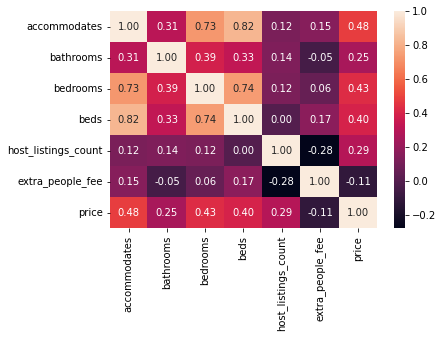

In [13]:
#Visualise the coorelation between the price and other columns
cols = ['accommodates','bathrooms','bedrooms','beds',
        'host_listings_count', 'extra_people_fee', 'price']
heatmap = sns.heatmap(df[cols].corr(), annot=True, fmt='.2f')

#Plot and save
fig = heatmap.get_figure()
fig.savefig("Correlation_Matrix.png") 

From the figure above. We can observe that the price of the property price coorelates the highest with number of accomdates number of bedrooms and beds. 

/opt/conda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


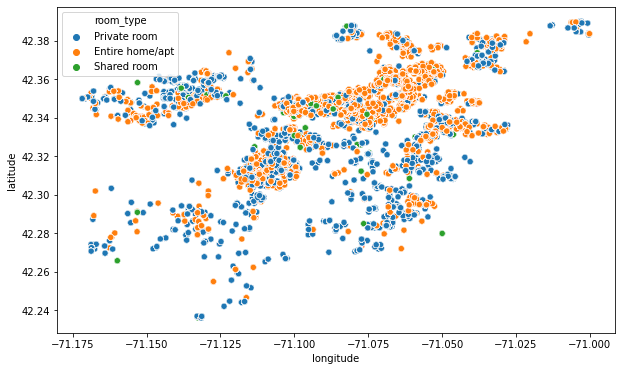

In [14]:
#room_type distribution according to the longitude and latitude
# Tip: If this sns.scatterplot() didn't work, please upgrade seaborn via "!pip install seaborn --upgrade" and restart the kernel.

fig_map = plt.figure(figsize=(10,6))
ax = sns.scatterplot(df.longitude, df.latitude, data=df, hue='room_type')
fig_map.savefig("map.png")
ax;

---

## Modeling

See if we can we create a machine learning model that predicts the price given this dataset?

In [15]:
# Helper function to create dummy df
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df


In [16]:
# Select categorial cols and change it with dummy vars

cat_vars =[ 'neighbourhood_cleansed',
             'property_type',
             'room_type',
             'bed_type',
             'cancellation_policy',
             'host_is_superhost',
             'instant_bookable',
             'is_location_exact',
             'require_guest_phone_verification',
             'require_guest_profile_picture',
             'host_has_profile_pic',
             'host_identity_verified',
             'host_response_time'
          ]
             
df_new = create_dummy_df(df, cat_vars, dummy_na=False) 

In [17]:
#Test here to check if there is any cat data or nan values in the new DataFrame

percent_missing = df_new.isnull().sum() * 100 / len(df_new)
columns_with_nan = percent_missing[percent_missing > 0]
print("columns with nans", columns_with_nan)

cat_columns = list(df_new.select_dtypes(include=['object']).columns)
print("cols of dtype object", cat_columns)

columns with nans Series([], dtype: float64)
cols of dtype object []


### Linear Regression Model

In [18]:
#Prepare the X and response vector
X = df_new.drop(columns = 'price')
y = df_new[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Instantiate the model
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)

#Predict
y_test_preds= lm_model.predict(X_test)

#Scoring
r_test = r2_score(y_test, y_test_preds)

### Linear Regression Evaluation

In [19]:
#Linear Regression output
print("Linear regression model output")
print("Mean Squared Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_test_preds)))
print("R2 Score: ",r_test * 100)
print("Mean Absolute Error: ", mean_absolute_error(y_test,y_test_preds))
print("Mean Squareroot Error: ", mean_squared_error(y_test,y_test_preds))

Linear regression model output
Mean Squared Error:  133.3293956674984
R2 Score:  44.5641170815415
Mean Absolute Error:  62.63089866032156
Mean Squareroot Error:  17776.72774906034


Linear regression model predictions
   actual_values  predicted_values
0          723.0        439.946746
1           36.0         91.859391
2          140.0        164.479917
3          100.0        119.306717
4          185.0        170.387024
5           80.0        148.971143
6           89.0         83.010357
7           58.0         36.823665
8           55.0         59.130126
9           48.0         50.718908


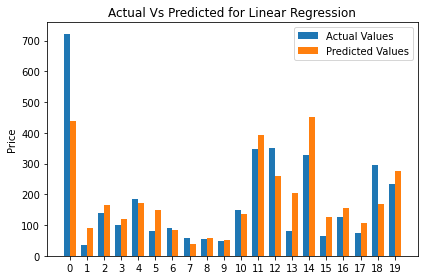

In [20]:
#Actual Vs Predicted for Linear Regression
diff_df_lm = pd.DataFrame({
        'actual_values': np.array(y_test).flatten(),
        'predicted_values': y_test_preds.flatten()}).head(20)

print("Linear regression model predictions")
print(diff_df_lm.head(10))

x = diff_df_lm.index
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, diff_df_lm.actual_values, width, label='Actual Values')
rects2 = ax.bar(x + width/2, diff_df_lm.predicted_values, width, label='Predicted Values')
ax.set_ylabel('Price')
ax.set_title('Actual Vs Predicted for Linear Regression')
ax.set_xticks(x)
ax.legend()
fig.tight_layout()
fig.savefig("Actual Vs Predicted for Linear Regression.png")
plt.show()

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


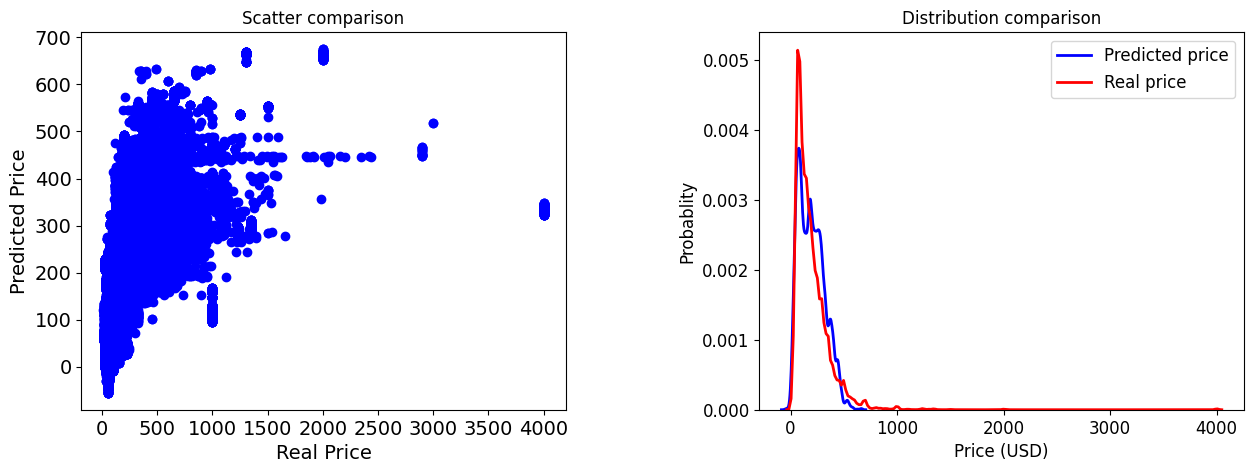

In [21]:
#Comparison of distribution
fig = plt.figure(figsize =(15, 5),dpi=100)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = plt.axes(aspect = 'equal')
plt.subplot(121)
plt.title('Scatter comparison', fontsize=12)
plt.scatter(y_test, y_test_preds, color='blue')
plt.xlabel('Real Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(122)
sns.distplot(y_test_preds, hist=False,
             kde_kws={'color': 'b', 'lw': 2, 'label': 'Predicted price'})
sns.distplot(y_test, hist=False,
             kde_kws={'color': 'r', 'lw': 2, 'label': 'Real price'})
plt.title('Distribution comparison', fontsize=12)
plt.ylabel('Probablity', fontsize=12)
plt.xlabel('Price (USD)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Predicted price', 'Real price'], prop={"size":12})
fig.savefig("Linear Regression Distribution Comparison.png")
plt.show()

#### Observations

 1. The predicted value is close to the actual value in some cases.
 2. It is obvious that it deviates when the price is high.

Decision: Let's see if we can do better with Random Forest.
 

### Random Forest ML

In [22]:
#Train RF regressor model
#initiate
forest = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1)
#fit the model
forest.fit(X_train, y_train.squeeze())

#calculate scores for the model
y_train_preds = forest.predict(X_train)
y_test_preds = forest.predict(X_test)

#Scoring
r_test_scorerm = r2_score(y_test, y_test_preds)

### Random Forest Regression Model Evaluation

In [23]:
#RF output
print("Random forest regression model output")
print("Mean Squared Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_test_preds)))
print("R2 Score: ",r_test_scorerm * 100)
print("Mean Absolute Error: ", mean_absolute_error(y_test,y_test_preds))
print("Mean Squareroot Error: ", mean_squared_error(y_test,y_test_preds))

Random forest regression model output
Mean Squared Error:  37.463386094941654
R2 Score:  95.6232352513374
Mean Absolute Error:  8.596092921269943
Mean Squareroot Error:  1403.5052976986678


Random forest regression model predicitions
   actual_values  predicted_values
0          723.0        527.953819
1           36.0         36.000000
2          140.0        140.000000
3          100.0        100.000000
4          185.0        190.412926
5           80.0         97.511587
6           89.0         88.058062
7           58.0         53.626257
8           55.0         55.000000
9           48.0         48.000000


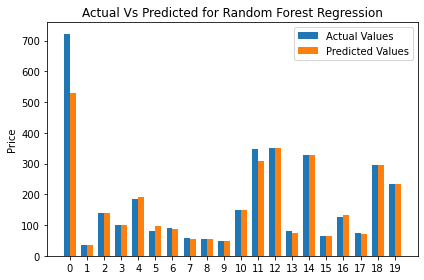

In [24]:
#Actual Vs Predicted for Random Forest Regression
diff_df_rf = pd.DataFrame({
        'actual_values': np.array(y_test).flatten(),
        'predicted_values': y_test_preds.flatten()}).head(20)
print("Random forest regression model predicitions")
print(diff_df_rf.head(10))

x = diff_df_rf.index
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, diff_df_rf.actual_values, width, label='Actual Values')
rects2 = ax.bar(x + width/2, diff_df_rf.predicted_values, width, label='Predicted Values')
ax.set_ylabel('Price')
ax.set_title('Actual Vs Predicted for Random Forest Regression')
ax.set_xticks(x)
ax.legend()
fig.tight_layout()
fig.savefig("Actual Vs Predicted for Random Forest regression.png")
plt.show()

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


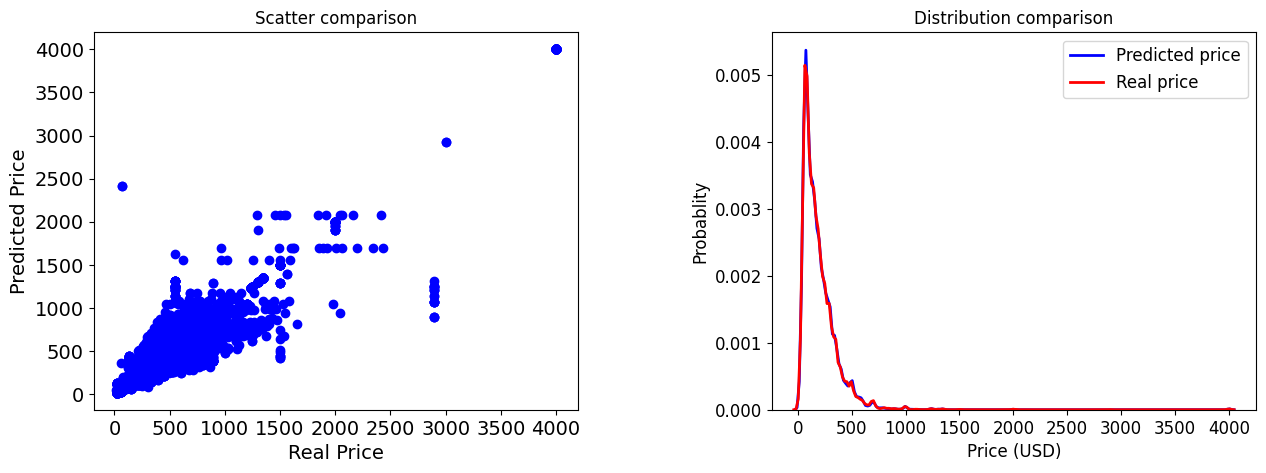

In [25]:
#Comparison of distribution
fig = plt.figure(figsize =(15, 5),dpi=100)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = plt.axes(aspect = 'equal')
plt.subplot(121)
plt.title('Scatter comparison', fontsize=12)
plt.scatter(y_test, y_test_preds, color='blue')
plt.xlabel('Real Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(122)
sns.distplot(y_test_preds, hist=False,
             kde_kws={'color': 'b', 'lw': 2, 'label': 'Predicted price'})
sns.distplot(y_test, hist=False,
             kde_kws={'color': 'r', 'lw': 2, 'label': 'Real price'})
plt.title('Distribution comparison', fontsize=12)
plt.ylabel('Probablity', fontsize=12)
plt.xlabel('Price (USD)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Predicted price', 'Real price'], prop={"size":12})
fig.savefig("Random Forest Regression Distribution Comparison.png")
plt.show()